## Decoding

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from sklearn.model_selection import train_test_split
 
torch.set_grad_enabled(True)
torch.set_printoptions(linewidth =120)
 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
from sklearn.metrics import confusion_matrix
#from plotcm import plot_confusion_matrix
 
import pdb

In [2]:

for i in range(36):
    if i ==0:
        continue

    elif i ==1:
        trainHG = np.concatenate((np.load('HG_noise_dataset0.npz')['data'],np.load('HG_noise_dataset1.npz')['data']),axis = 0)
    else:
        trainHG = np.concatenate((trainHG,np.load('HG_noise_dataset'+str(i)+'.npz')['data']),axis = 0)
        

for i in range(36):
    if i ==0:
        continue

    elif i ==1:
        labelHG = np.concatenate((np.load('HG_noise_dataset0.npz')['target'],np.load('HG_noise_dataset1.npz')['target']),axis = 0)
    else:
        labelHG = np.concatenate((labelHG,np.load('HG_noise_dataset'+str(i)+'.npz')['target']),axis = 0)
    
    
print(np.shape(trainHG))
print(np.shape(labelHG))


(3600, 16, 16)
(3600, 1)


## Dataset 

In [3]:
####Custom dataset###    
class Data(Dataset):
    
    def __init__(self,xdata,ydata):
        self.x = np.array(xdata)
        self.y = np.array(ydata)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        
        x = torch.FloatTensor(self.x[idx])
        y = torch.FloatTensor(self.y[idx])
        
        return x,y

l = 3600
s=0.2
n=3
data = np.array(trainHG).reshape(l,-1)
label = np.array(labelHG).reshape(-1,1)

x_train, X_test, y_train, Y_test = train_test_split(data, 
                                                    label, test_size=s, 
                                                    shuffle=True, 
                                                    stratify=label, random_state=34)
sample = np.load('Dataset1.npz')
train_x = sample['data']
train_y = sample['target']

dataset = Data(x_train,y_train)   
dataloader = DataLoader(dataset,5,shuffle = True)

test_x = torch.FloatTensor(torch.FloatTensor(X_test)).view(-1,1,16,16)
test_y = torch.FloatTensor(torch.FloatTensor(Y_test)).view(-1,1)

## Model

In [4]:


class DecodingCNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.keep_prob = 0.5
        
        #Layer 1
        #chennel : 1, height : 16, width : 16
        #conv : (1,16,16,2)
        #pool : (1,8,8,2)      
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1,2,kernel_size = 3,stride =1,padding=1),
            torch.nn.ReLU(),torch.nn.MaxPool2d(kernel_size=2, stride=2),nn.BatchNorm2d(2))
        
        #Layer 2
        #chennel : 1, height : 16, width : 16
        #conv : (1,8,8,4)
        #pool : (1,4,4,4)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(2,4,kernel_size = 3,stride =1,padding=1),
            torch.nn.ReLU(),torch.nn.MaxPool2d(kernel_size=2, stride=2),nn.BatchNorm2d(4))
        
        #Layer 3
        #chennel : 1, height : 16, width : 16
        #conv : (1,4,4,8)
        #pool : (1,2,2,8)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(4,8,kernel_size = 3,stride =1,padding=1),
            torch.nn.ReLU(),torch.nn.MaxPool2d(kernel_size=2, stride=2),nn.BatchNorm2d(8))
        
        self.fc1 = torch.nn.Linear(2*2*8,100,bias = True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        
        
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.Dropout(p=1-self.keep_prob))
        
        #Layer 5
        self.fc2 = torch.nn.Linear(100,36,bias = True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)      
        
    def forward(self,x):
        
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.layer4(out)
        out = self.fc2(out)
        
        return out
        

In [5]:
model = DecodingCNN()
#model(torch.FloatTensor(5,1,16,16))

In [6]:
#cost/loss
criterian = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001)

In [7]:
#traning
total_batch = len(dataloader)
num = 50
accuracy_list = []
print("Learning strated. It takes sometime")
for epoch in range(num):
    
    avg_cost =0
    correct = []
    
    for X,Y in dataloader:

        X = torch.reshape(X,(-1,1,16,16))
        Y = torch.reshape(Y,(-1,5)).flatten()
        Y = Y.type(torch.LongTensor)
        optimizer.zero_grad()
        hypothesis = model(X)
        
        cost = criterian(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))
    
    # Test model and check accuracy
with torch.no_grad():
    
    X_test = test_x
    Y_test = test_y

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction,1)==Y_test.flatten()
    accuracy = correct_prediction.float().mean()
    
    print('Accuracy:', accuracy.item())

Learning strated. It takes sometime


C:\Aanaconda\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[Epoch:    1] cost = 3.76621366
[Epoch:    2] cost = 2.96631265
[Epoch:    3] cost = 2.37855005
[Epoch:    4] cost = 1.8777833
[Epoch:    5] cost = 1.51130021
[Epoch:    6] cost = 1.22796047
[Epoch:    7] cost = 1.03256941
[Epoch:    8] cost = 0.866569519
[Epoch:    9] cost = 0.711681902
[Epoch:   10] cost = 0.603395224
[Epoch:   11] cost = 0.543478251
[Epoch:   12] cost = 0.475704134
[Epoch:   13] cost = 0.409228653
[Epoch:   14] cost = 0.353325784
[Epoch:   15] cost = 0.321620315
[Epoch:   16] cost = 0.28223905
[Epoch:   17] cost = 0.252035171
[Epoch:   18] cost = 0.239267945
[Epoch:   19] cost = 0.212767899
[Epoch:   20] cost = 0.186724871
[Epoch:   21] cost = 0.160298094
[Epoch:   22] cost = 0.169623911
[Epoch:   23] cost = 0.150605306
[Epoch:   24] cost = 0.142258197
[Epoch:   25] cost = 0.122620784
[Epoch:   26] cost = 0.132377118
[Epoch:   27] cost = 0.122324288
[Epoch:   28] cost = 0.0998127833
[Epoch:   29] cost = 0.103347287
[Epoch:   30] cost = 0.0927208215
[Epoch:   31] cos

In [8]:
Y_test = torch.reshape(Y_test,(-1,1)).flatten()
Y_test = Y_test.type(torch.LongTensor)
stacked = torch.stack(
    (
        torch.argmax(prediction, 1)
        ,torch.reshape(Y_test,(-1,1)).flatten()
    )
    ,dim=1
)

stacked.shape

cmt = torch.zeros(36,36, dtype=torch.int64)
cmt

for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

cmt

tensor([[20,  0,  0,  ...,  0,  0,  0],
        [ 0, 19,  0,  ...,  0,  0,  0],
        [ 0,  1, 20,  ...,  0,  0,  0],
        ...,
        [ 0,  0,  0,  ..., 20,  0,  0],
        [ 0,  0,  0,  ...,  0, 20,  0],
        [ 0,  0,  0,  ...,  0,  0, 19]])

Confusion matrix, without normalization
tensor([[20,  0,  0,  ...,  0,  0,  0],
        [ 0, 19,  0,  ...,  0,  0,  0],
        [ 0,  1, 20,  ...,  0,  0,  0],
        ...,
        [ 0,  0,  0,  ..., 20,  0,  0],
        [ 0,  0,  0,  ...,  0, 20,  0],
        [ 0,  0,  0,  ...,  0,  0, 19]])


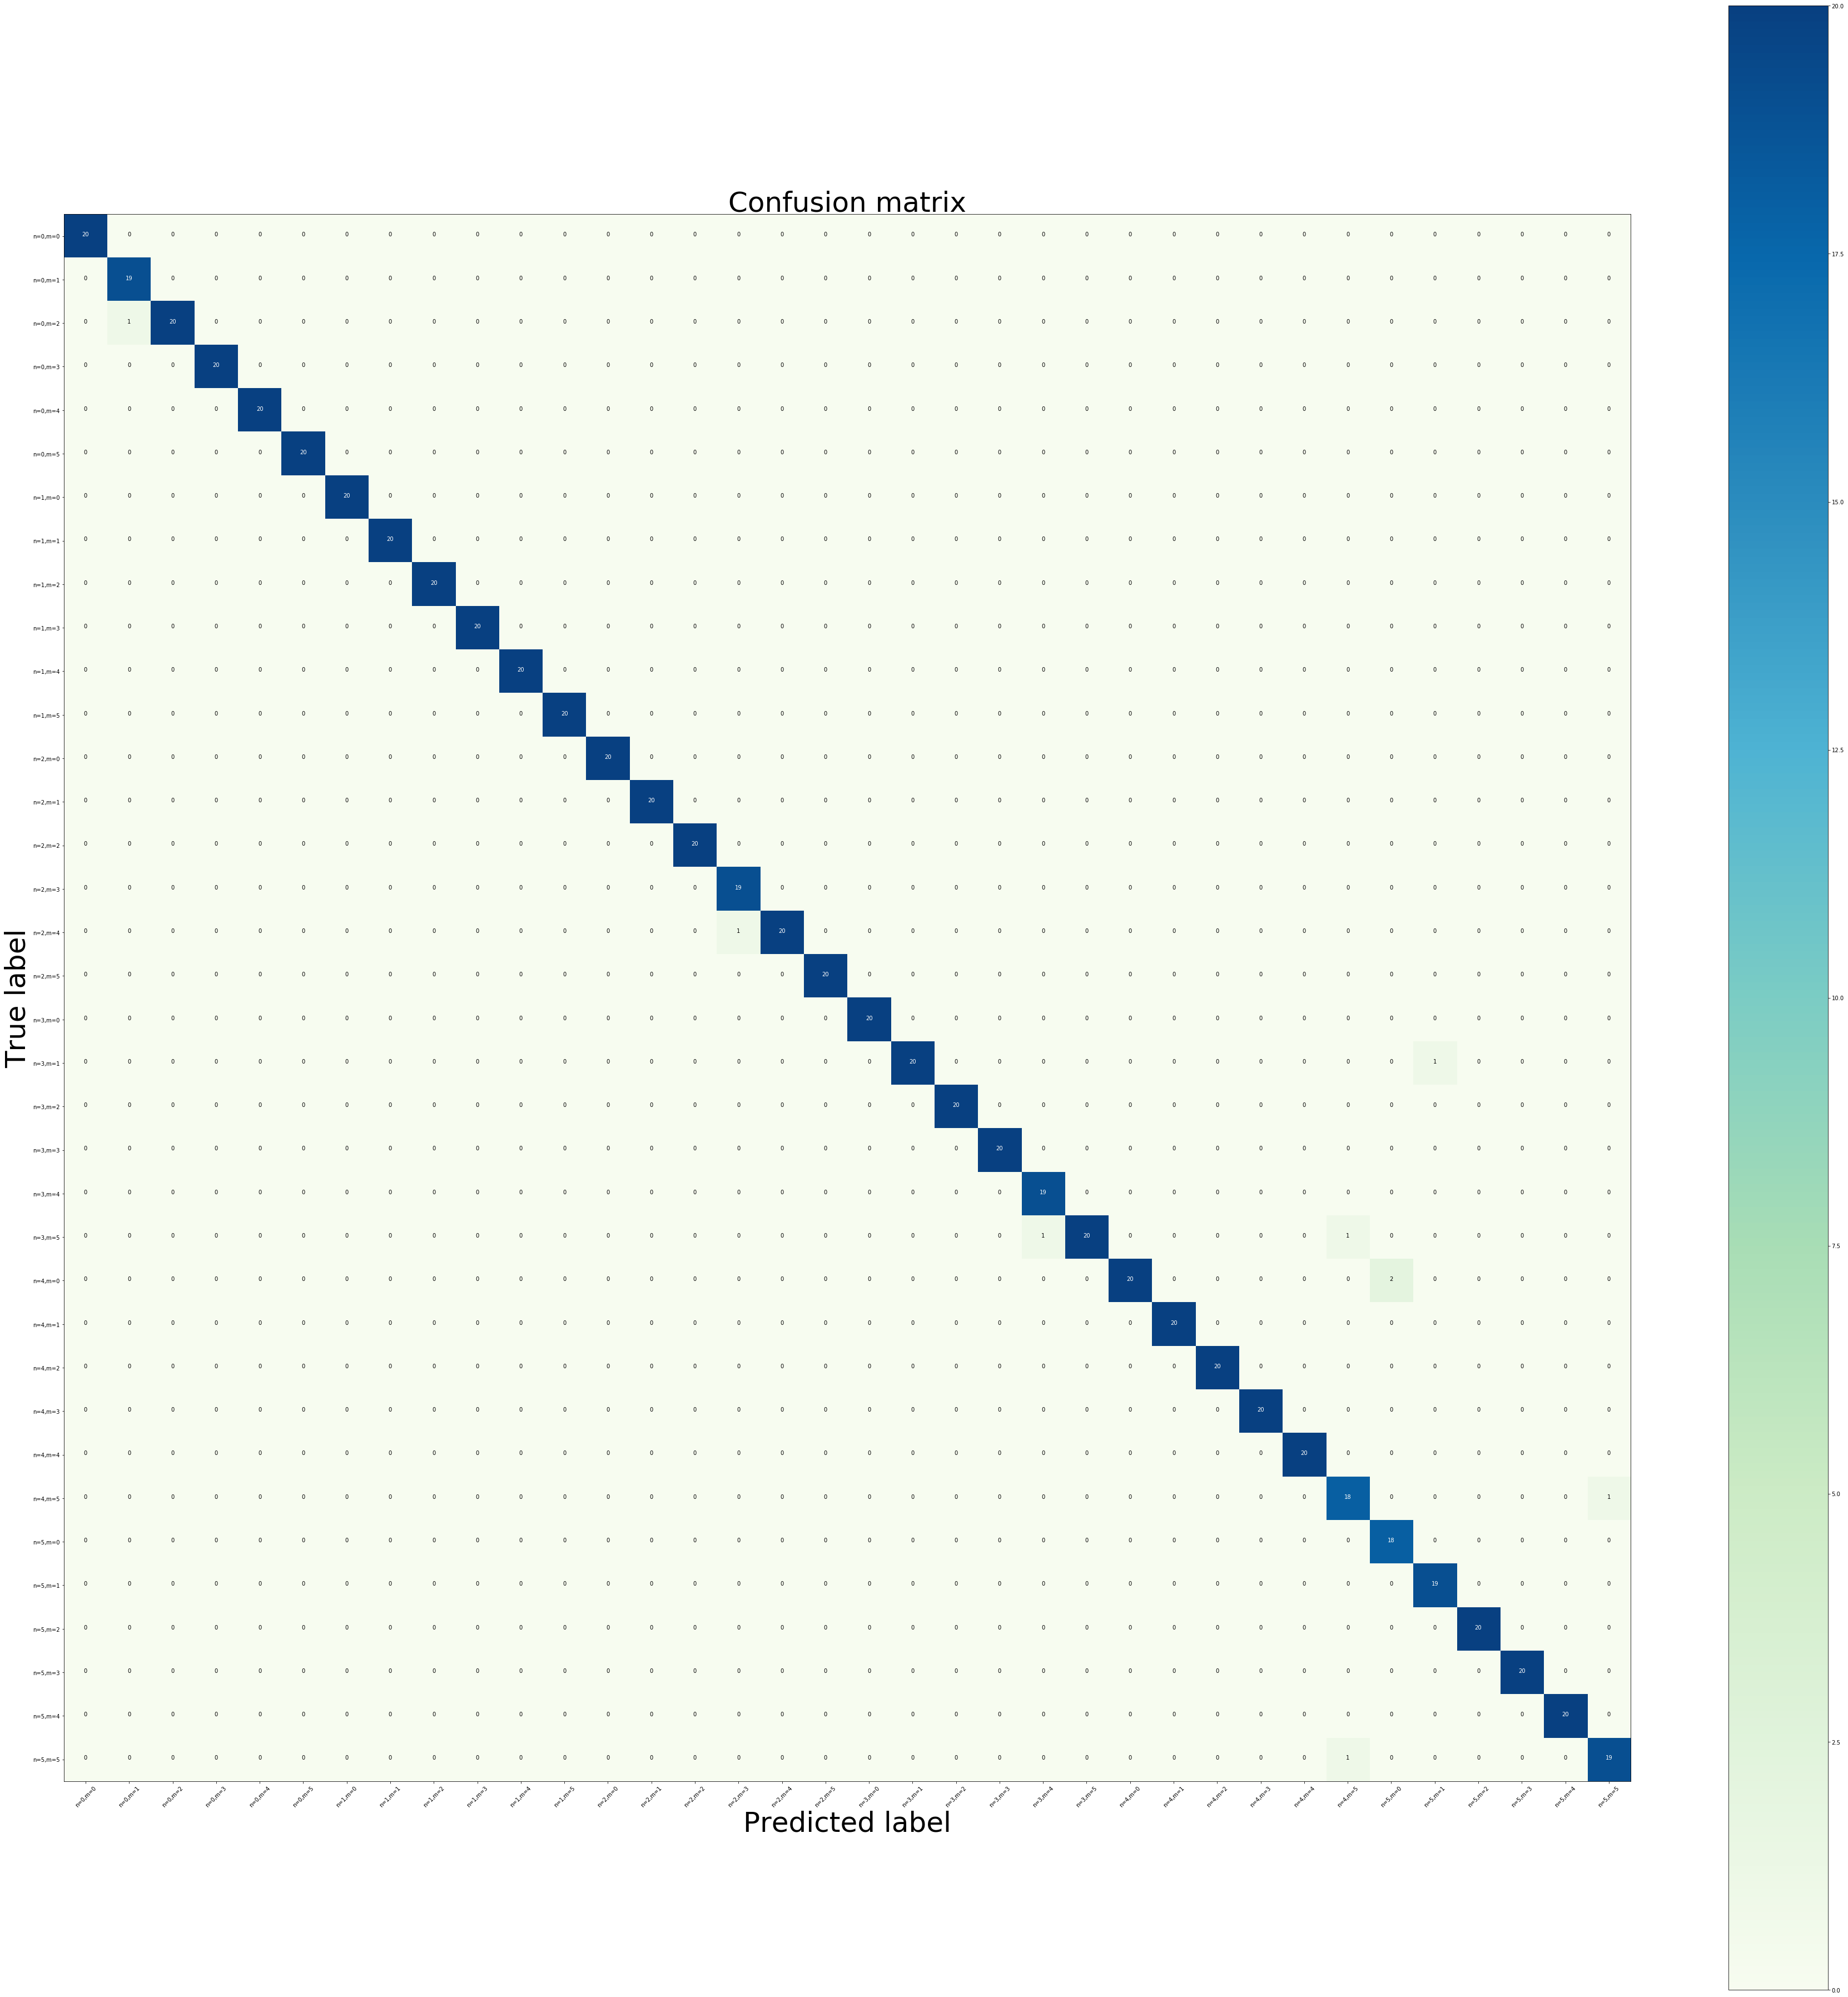

In [9]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
 
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.GnBu):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize = 50)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label',fontsize = 50)
    plt.xlabel('Predicted label',fontsize = 50)


names = (
    'n=0,m=0','n=0,m=1','n=0,m=2','n=0,m=3','n=0,m=4','n=0,m=5'
    ,'n=1,m=0' ,'n=1,m=1','n=1,m=2','n=1,m=3','n=1,m=4','n=1,m=5'
    ,'n=2,m=0','n=2,m=1','n=2,m=2','n=2,m=3','n=2,m=4','n=2,m=5'
    ,'n=3,m=0','n=3,m=1','n=3,m=2','n=3,m=3','n=3,m=4','n=3,m=5'
    ,'n=4,m=0','n=4,m=1','n=4,m=2','n=4,m=3','n=4,m=4','n=4,m=5'
    ,'n=5,m=0','n=5,m=1','n=5,m=2','n=5,m=3','n=5,m=4','n=5,m=5'
)
plt.figure(figsize=(50,50))
plot_confusion_matrix(cmt, names)